In [16]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

In [18]:
# Выбор порта данных с катушек
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for i, port in enumerate(ports):
    # print(f"{port}")
    print(f"Порт {i}: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")
if port:
    # prt = int(input('Какой порт?'))
    port = ports[0].device
    port_motor = ports[1].device
    print(f'Для получения данных выбран порт - {port}')
    print(f'Для двигателя выбран порт - {port_motor}')

Порт 0: COM6
Порт 1: COM7
Для получения данных выбран порт - COM6
Для двигателя выбран порт - COM7


In [19]:
# Отправка команды на вращение магнита
with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
    # Read data from COM port
    revolutions = 26
    distance=1000/9
    speed=100
    command = f'ON\rMOVE L(-{int(revolutions * distance)})F({int(speed)})\rOFF\r'
    serialData.write(command.encode(encoding="utf-8"))

# Чтение данных с катушек в память контроллера
time.sleep(3)
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
    # Read data from COM port
    command = 'R'
    # Send the command to the DataPort
    serialData.write(command.encode(encoding="utf-8"))
    # serialline.flush()
time.sleep(11)

In [ ]:
# Получение данных с выбранного порта в память компьютера
rawdata = None
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=46)) as serialData:
    # Read data from COM port
    command = 'S'
    # Send the command to the DataPort
    serialData.write(command.encode())
    # Get data
    rawdata_bytes = serialData.read(4194304)

In [222]:
raw_signal = rawdata[:2097152]
# Чтение по два байта (старший-младший) в нотации "big-endian" с переводом в нотацию компилятора (little-endian)
data = raw_signal.view(dtype='>i2').astype(np.int16)

raw_encoder = rawdata[2097152:]
encoder = raw_encoder.view(dtype='>i2').astype(np.int16)

df_raw = pd.DataFrame({
    'encoder': encoder,
    'data': data
})


In [ ]:
# Перевод данных из битов в целые числа по старому
if 0:
    data = []
    for num in range(0, 2097152, 2):
        hi_byte = rawdata_bytes[num]
        hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
        lo_byte = rawdata_bytes[num+1]    
        data.append(hi_byte*256+lo_byte)
    # print(len(data))

    encoder = []
    for num in range(2097152, len(rawdata_bytes), 2):
        hi_byte = rawdata_bytes[num]
        hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
        lo_byte = rawdata_bytes[num+1]    
        encoder.append(hi_byte*256+lo_byte)
    # print(len(encoder))

    df_raw = pd.DataFrame({'encoder' : encoder, 'data' : data})

,encoder,data
0,2137,8546
1,2137,6787
2,2137,6830
3,2137,7120
4,2137,7181
...,...,...
1048571,4321,2532
1048572,4321,2419
1048573,4321,2380
1048574,4321,2478


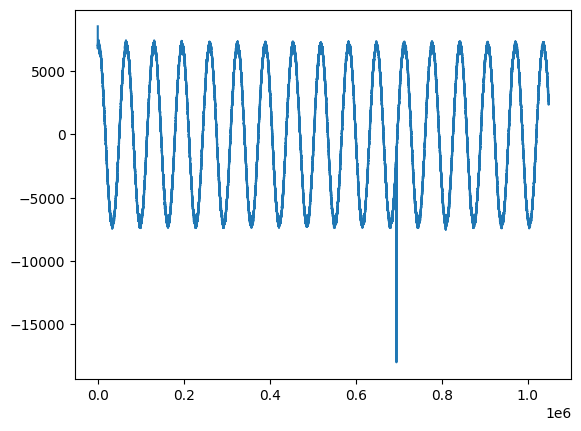

In [223]:
plt.plot(df_raw.data)
df_raw


In [232]:
# Фильтрация данных от дельта-шумов
window_size = 3
df_filtered = pd.DataFrame(columns=['data', 'encoder'])
df_filtered.data = medfilt(df_raw.data, kernel_size=window_size)[window_size*2:-window_size*2]
df_filtered.encoder = medfilt(df_raw.encoder, kernel_size=window_size)[window_size*2:-window_size*2]

# Отрезаем целое число периодов
split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]
start_idx = split_points[0]
end_idx = split_points[-1]
df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

In [234]:
df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969881 entries, 50750 to 1020630
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   data     969881 non-null  int16
 1   encoder  969881 non-null  int16
dtypes: int16(2)
memory usage: 3.7 MB


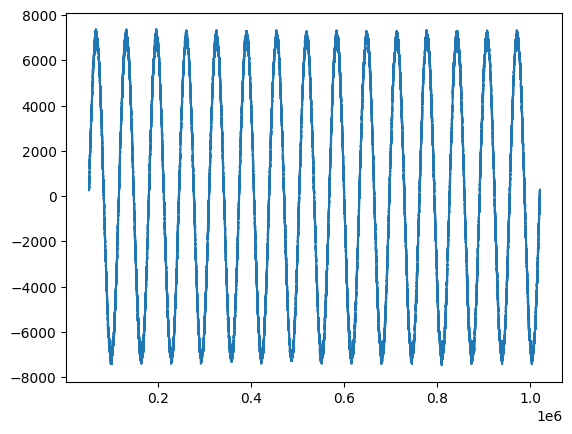

In [225]:
plt.plot(df_trimmed.data)

In [227]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
# Добавим столбец, который идентифицирует периоды непрерывных значений encoder
df_trimmed['period'] = (df_trimmed['encoder'] != df_trimmed['encoder'].shift()).cumsum()

# Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
df_res = df_trimmed.groupby('period').agg({'data': 'sum', 'encoder': 'max'}).reset_index().drop('period', axis=1)

df_res['integral'] = -1.0*df_res.data.cumsum()

# 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
df_res['volts'] = (2.5/32767 * 1/96937 * 1/1144.8)*df_res.integral

df_res['deg'] = df_res.index/10000*360

In [35]:
# filename = f"data_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
# dir = 'data'

# df_res.to_csv(os.path.join(dir, filename))

# plt.plot(df_res.volts)
# df_res

In [228]:
import fastgoertzel as fg

f_amp, f_phase = fg.goertzel(df_res.volts.values, 1/10000)
f_phase = (f_phase+np.pi/2)*180/np.pi
print(f'Fast Goertzel Amp: {f_amp:.5e}, {f_phase = :.3f}°')

Fast Goertzel Amp: 5.02493e-05, f_phase = 93.828°


In [37]:
# df = df_res.copy()
# signal = 'volts'

# PT = 10000 # точек на период
# N = len(df)-len(df)%PT # 150000 количество отсчетов
# # omega0 = 2*np.pi/PT # угловая частота
# k = int(N/PT) # номер гармоники
# alpha = 2*np.cos(2*np.pi*k/N)

# df['s'] = 0.0

# n = 0
# df.loc[n, 's'] = df.loc[n, signal] + alpha*0 - 0
# n = 1
# df.loc[n, 's'] = df.loc[n, signal] + alpha*df.loc[n-1, 's'] - 0

# for n in range(2, len(df)):
#     df.loc[n, 's'] = df.loc[n, signal] + alpha*df.loc[n-1, 's'] - df.loc[n-2, 's']

# F2 = df.loc[N-1, 's']
# F3 = df.loc[N-2, 's']

# real = F2*np.cos(2*np.pi*k/N)-F3
# imag = F2*np.sin(2*np.pi*k/N)

# s_amp = np.sqrt(real**2 + imag**2)*2/N 
# s_phi = (np.arctan2(imag, real)+np.pi/2)*180/np.pi

# # amp = 1/1144.8 * amp # 2.5/32767 - Volts ; 1/96937 - sec ; 1/1144.8 - m

# print(f'Slow Goertzel Amp: {s_amp:.5e}, {s_phi = :.3f}°')

Найдено локальных максимумов: 16
Найдено локальных минимумов: 15
   Амплитуда = 8.25764e-07 ± 1.4e-09
   Относительная погрешность: 0.1637%


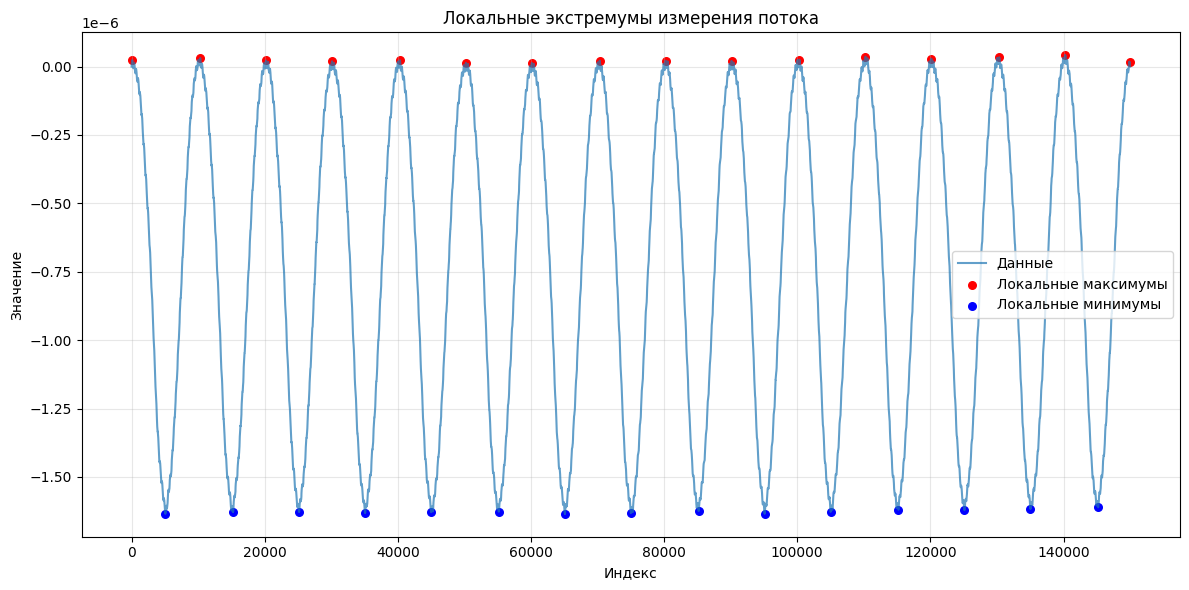

In [38]:
# Находим амплитуду из максимумов
df = df_res.copy()
data_column = 'detrend'

x = df.volts.index.values
y = df.volts.values

# Координаты первой и последней точек
x0, x1 = x[0], x[-1]
y0, y1 = y[0], y[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем трендовую составляющую и вычитаем
trend = a * x + b
df[data_column] = (y - trend)

# Локальные максимумы
local_maxima = argrelextrema(df[data_column].values, np.greater, order=1000)[0]
# Локальные минимумы
local_minima = argrelextrema(df[data_column].values, np.less, order=1000)[0]

print(f"Найдено локальных максимумов: {len(local_maxima)}")
print(f"Найдено локальных минимумов: {len(local_minima)}")

# Добавляем метки в DataFrame
df['is_local_max'] = False
df['is_local_min'] = False

df.loc[local_maxima, 'is_local_max'] = True
df.loc[local_minima, 'is_local_min'] = True

# Извлечение экстремумов
maxima = df[df['is_local_max']]
minima = df[df['is_local_min']]

# Вычисляем средние значения
mean_max = maxima[data_column].mean()
mean_min = minima[data_column].mean()

# Разность средних
amplitude = (mean_max - mean_min)/2

# 3. Вычисляем погрешности
# Погрешность среднего значения максимумов
std_max = maxima[data_column].std(ddof=1)
std_error_max = std_max / np.sqrt(len(maxima))

# Погрешность среднего значения минимумов
std_min = minima[data_column].std(ddof=1)
std_error_min = std_min / np.sqrt(len(minima))

# Абсолютная погрешность амплитуды (по формуле погрешности разности)
absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# Относительная погрешность амплитуды
relative_error = absolute_error / amplitude * 100  # в процентах

print(f"   Амплитуда = {amplitude:.5e} ± {absolute_error:.2}")
print(f"   Относительная погрешность: {relative_error:.4f}%")

%matplotlib inline
data_column = 'detrend'

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[data_column], label='Данные', alpha=0.7)
plt.scatter(local_maxima, df.loc[local_maxima, data_column], 
           color='red', label='Локальные максимумы', s=30)
plt.scatter(local_minima, df.loc[local_minima, data_column], 
           color='blue', label='Локальные минимумы', s=30)
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Локальные экстремумы измерения потока')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('extrema_plot.png', dpi=300)
plt.show()

In [10]:
Goertzel_Amp1 = 5.02492e-05
Goertzel_Amp2 = 5.07023e-05
Goertzel_Amp3 = 9.35180e-07

amps1 = [Goertzel_Amp1, Goertzel_Amp2, Goertzel_Amp3]

f_phase1 = 93.697
f_phase2 = 181.772
f_phase3 = 120.873

PeakAmp1 = 5.01997e-05
PeakAmp2 = 5.01941e-05
PeakAmp3 = 8.25764e-07

amps2 = [PeakAmp1, PeakAmp2, PeakAmp3]

# Измерение 1:   5.02003e-05 ± 5e-09 (0.01%) [В*с*м]
# Измерение 2:   5.01836e-05 ± 7e-08 (0.13%) [В*с*м]
# Измерение 3:   8.23969e-07 ± 1e-09 (0.16%) [В*с*м]
# Полный момент: 5.02e-05 [В*с*м]; Отклонение от нормали θz: 1.33°

In [13]:
import numpy as np

for amps in [amps1, amps2]:
    """Получить финальный результат измерений"""
    # Извлекаем амплитуды из всех трех измерений
    amplitudes = sorted(amps)

    # Вычисляем финальный результат по формуле
    sum_of_squares = sum(amp**2 for amp in amplitudes) / 2
    final_amplitude = np.sqrt(sum_of_squares)

    print(f'{final_amplitude:.5}') # {((final_amplitude - 5.02e-05)/final_amplitude * 100):.2}%

    # Угол отклонения от нормали (оси z)
    M_xy, M_yz, M_zx = amplitudes

    theta_rad = np.arctan(M_xy / (np.sqrt(M_yz**2 + M_zx**2 - M_xy**2)/2))
    theta_deg = np.degrees(theta_rad)

    print(f'{theta_deg:.3}')

5.0481e-05
1.5
5.02e-05
1.33


In [15]:
f'Разница - {((5.05e-05 - 5.02e-05)/5.05e-05 * 100):.2}%'

'Разница - 0.59%'

- 5.020e-05 1.33°
- 5.048e-05 1.50°